In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim 
import numpy as np
import os
from torch.utils.data import Dataset, DataLoader
from collections import defaultdict
from IPython.display import clear_output
from torchvision.datasets import MNIST
import matplotlib.pyplot as plt
from models import Encoder, Decoder, NeuroDataset
from itertools import combinations

from sklearn.manifold import LocallyLinearEmbedding, Isomap, SpectralEmbedding
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import pandas as pd

In [2]:
def calc_gradient_magnitude(named_parameters, silence=False):
    total_amplitude = []
    for name, p in named_parameters:
        # print(name)
        if p.grad is not None:
            param_amplitude = p.grad.data.abs().max()
            total_amplitude += [param_amplitude.item()]
        elif not silence:
            print (name, 'grad is None')    

    total_amplitude = max(total_amplitude)

    return total_amplitude

# EDA

 - В кольцевом треке (circle_track) и треке с отверстиями (holy_track).    
 - В каждом из треков n= 4 мыши (CA1_22, CA1_23, CA1_24 и CA1_25) провели 3 раза по 15 минут с интервалом в 1 сутки (отсюда индексы 1D, 2D, 3D).   
 - В треке с отверстиями их число менялось от 3х в первый день до 1го в третий.  
 
Данные имеют вид .csv таблиц (разделители — запятые), в первом столбце- время в секундах, далее идут столбцы с координатами центра масс мыши (x,y), затем координаты цветных маркеров на голове мыши (x_green, y_green, x_red, y_red; расположены как на рисунке в приложениии);   
Они есть только для кольцевого трека и фиксируются камерой не очень надёжно, так что в некоторых местах имеют разрывы — я старался их очистить, насколько это возможно, но не всё удалось отфильтровать, к сожалению.   

Координаты даны в пикселях, диаметр трека равен 50 см. После координат маркеров следуют столбцы с собственно нейронной активностью (т.е. интенсивностью флуоресценции;  данные получены путём применения алгоритма CNMF-E) для каждой из клеток.  
 
Для кольцевого трека есть аналогичные «сырым» данным нейронной активности данные по дискретным активациям каждой из клеток  — они состоят из амплитуд значимых (>4 MAD) событий в местах, где они происходят и нулей во всех остальных точках (по формату всё то же, что и с «сырыми» данными, только без координат). 

![sdf](./mouse_setup.png)

In [3]:
spikes_df = pd.read_csv("./Data_Calcium/Circle/CA1_22_1D_initial_data.csv", index_col=0)
spikes_events_df = pd.read_csv("./Data_Calcium/Circle/CA1_22_1D_initial_data_spikes.csv", index_col=0)
print('n_steps', 'n_electrodes', spikes_df.shape)
trim=50
spikes_df = spikes_df[trim:-trim]

n_steps n_electrodes (18775, 556)


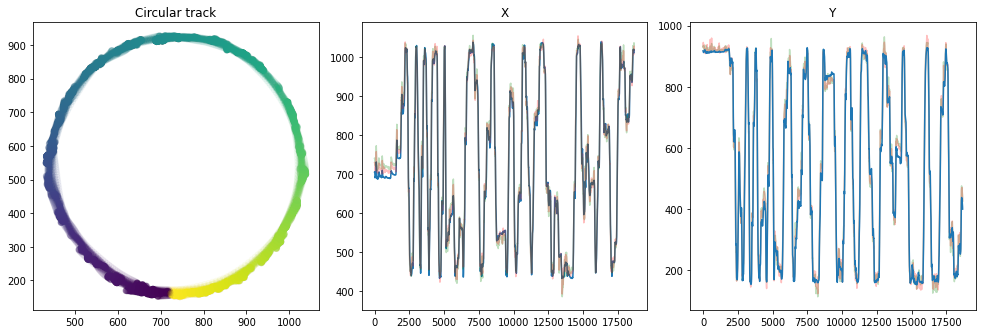

In [4]:
X = spikes_df["x"].to_numpy()
Y = spikes_df["y"].to_numpy()
X_green = spikes_df["x_green"].to_numpy()
Y_green = spikes_df["y_green"].to_numpy()
X_red = spikes_df["x_red"].to_numpy()
Y_red = spikes_df["y_red"].to_numpy()

coords = spikes_df[['x', 'y']].values
coords -= coords.mean(0)[None,:]
phi = np.arctan2(coords[:,0], coords[:,1])

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(13.75,4.75))
ax[0].set_title("Circular track")
ax[0].scatter(X, Y, alpha=0.05, c=phi)
ax[1].set_title("X")
ax[1].plot(X)
ax[1].plot(X_green, c="g", alpha=0.25)
ax[1].plot(X_red, c="r", alpha=0.25)
ax[2].set_title("Y")
ax[2].plot(Y_green, c="g", alpha=0.25)
ax[2].plot(Y_red, c="r", alpha=0.25)
ax[2].plot(Y)
plt.tight_layout()

In [5]:
X = spikes_df.iloc[:,7:].to_numpy()
X_std = StandardScaler().fit_transform(X)

# Choosing intrinsic dim

In [6]:
# from manifold_utils import repeated, intrinsic_dim_scale_interval

# n_samples = X_std.shape[0]
# k1 = min(10, n_samples//20)
# k2 = min(100, n_samples//4)

# intdim_k_repeated = repeated(intrinsic_dim_scale_interval, 
#                              X_std, 
#                              mode='bootstrap', 
#                              nb_iter=5,
#                              k1=k1, 
#                              k2=k2)
# intdim_k_repeated = np.array(intdim_k_repeated)

In [7]:
# neighbors = np.arange(k1, k2, 5)

# fig = plt.figure(figsize=(12,5.25))

# floor_n_ceil = np.concatenate((np.floor(np.mean(intdim_k_repeated, axis=0)).astype(int), 
#                                 np.ceil(np.mean(intdim_k_repeated, axis=0)).astype(int)))

# plt.subplot(121)
# plt.xlabel("Neighborhood cardinality")
# plt.ylabel("Intrinsic dimension")
# plt.grid(linestyle='dotted')

# plt.plot(np.arange(intdim_k_repeated.shape[1]) * 5 + 10, np.mean(intdim_k_repeated, axis=0), 'b')
# plt.plot(np.arange(intdim_k_repeated.shape[1]) * 5 + 10, np.mean(intdim_k_repeated, axis=0) + np.std(intdim_k_repeated, axis=0), 'r')
# plt.plot(np.arange(intdim_k_repeated.shape[1]) * 5 + 10, np.mean(intdim_k_repeated, axis=0) - np.std(intdim_k_repeated, axis=0), 'r')

# plt.subplot(122)
# plt.xlabel("Intrinsic dimension")
# plt.grid(linestyle="dotted")

# plt.hist(intdim_k_repeated.mean(axis=0))
# plt.show()

# Models

In [8]:
class AE(nn.Module):

    def __init__(self, orig_dim, inter_dim, code_dim, **kwargs):
        super().__init__()
        
        self.encoder = nn.Sequential(nn.Linear(orig_dim, inter_dim),
                                    nn.LeakyReLU(),
                                    nn.Linear(inter_dim, inter_dim),
                                    nn.LeakyReLU(),
                                    nn.Linear(inter_dim, code_dim))
        
        self.decoder = nn.Sequential(nn.Linear(code_dim, inter_dim),
                                    nn.LeakyReLU(),
                                    nn.Linear(inter_dim, inter_dim),
                                    nn.LeakyReLU(),
                                    nn.Linear(inter_dim, orig_dim))
    
    def forward(self, features):
        code = self.encoder.forward(features)
        reconstructed = self.decoder.forward(code)
        return reconstructed  

    def get_code_embedding(self, data):
        embedding = Encoder.forward(data)
        return embedding.detach().numpy()

In [9]:
class VAE(nn.Module):
    def __init__(self, orig_dim, inter_dim, code_dim, use_pxz_dist=False, **kwargs):
        super(VAE, self).__init__()
        self.use_pxz_dist = use_pxz_dist
        
        self.output_dim = 2*orig_dim if self.use_pxz_dist else orig_dim
        
        self.encoder = nn.Sequential(nn.Linear(orig_dim, inter_dim),
                                    nn.LeakyReLU(),
                                    nn.Linear(inter_dim, inter_dim),
                                    nn.LeakyReLU(),
                                    nn.Linear(inter_dim, 2*code_dim))
        
        self.decoder = nn.Sequential(nn.Linear(code_dim, inter_dim),
                                    nn.LeakyReLU(),
                                    nn.Linear(inter_dim, inter_dim),
                                    nn.LeakyReLU(),
                                    nn.Linear(inter_dim, self.output_dim))
        
        self.orig_dim = orig_dim
        self.inter_dim = inter_dim
        self.code_dim = code_dim
        
    def reparameterization(self, mu, logsigma):
        """
        :param mu: mean from the encoder's latent space
        :param logsigma: log sigma from the encoder's latent space
        """
        std = torch.exp(logsigma) # standard deviation
        eps = torch.randn_like(std) # `randn_like` as we need the same size
        sample = mu + (eps * std) # sampling as if coming from the input space
        return sample
    
    def get_code(self, features):
        x = self.encoder.forward(features)
        
        #print('x shape:', x.shape)
        x = x.view(-1, 2, self.code_dim)

        # get `mu` and `logsigma`
        mu = x[:, 0, :] # the first feature values as mean
        logsigma = x[:, 1, :] # the other feature values as squared root of variance
        
        if model.training:
            # get the latent vector through reparameterization
            code = self.reparameterization(mu, logsigma)
        else:
            code = mu

        return code, mu, logsigma
        
    def forward(self, features):
        # encoding
        code, mu_z, logsigma_z = self.get_code(features)

        # decoding
        reconstruction_params = self.decoder(code)
        if self.use_pxz_dist:
            reconstruction_params = reconstruction_params.view(-1, 2, self.orig_dim)
            mu_gen = reconstruction_params[:, 0, :]
            logsigma_gen = reconstruction_params[:, 1, :]
        else:
            mu_gen = reconstruction_params
            logsigma_gen = None
        return mu_gen, logsigma_gen, mu_z, logsigma_z
    
    def get_code_embedding(self, dataset):
        Encoder = self.encoder
        input = torch.tensor(dataset.data).float()
        embedding, mu, logsigma = self.get_code(input)

        return embedding.detach().numpy().T

In [10]:
def validate(model, val_loader, loss_type):
    model.eval()
    history = defaultdict(list)
    with torch.no_grad():
        for itr, data in enumerate(val_loader):   
            
            data = data.float().to(device)
            
            if model.__class__.__name__ == 'AE':
                mu_gen = model(data)
            elif model.__class__.__name__ == 'VAE':
                mu_gen, logsigma_gen, mu_z, logsigma_z = model(data)
            else: 
                raise RuntimeError()
    
            if loss_type == 'mse':
                train_loss = criterion(mu_gen, data)
                kld_loss, loss = torch.tensor(0), torch.tensor(0)
            elif loss_type == 'nll':
                train_loss, kld_loss, loss = loss_vae(data, mu_gen, logsigma_gen, mu_z, logsigma_z)
            elif loss_type == 'bce':
                loss = F.binary_cross_entropy(mu_gen, data, reduction='sum')
                kld_loss = KL_divergence(mu_z, logsigma_z)
                train_loss = loss + kld_loss
            else:
                raise RuntimeError()
            
            MAE = torch.norm(data - mu_gen, p=1, dim=1) / torch.norm(data, p=1, dim=1)
            MAE = MAE.mean()

            history['total_loss'].append(train_loss.item())
            history[f'{loss_type}_loss'].append(loss.item())
            history['kld_loss'].append(kld_loss.item())
            history['MAE'].append(MAE.item())
    history = {k:np.mean(v) for k,v in history.items()}
    
    fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(15,10))
    for i,ax in enumerate(axes.flatten()):
        ax.plot(data[i].detach().cpu().numpy(), label='original', alpha=0.6)
        ax.plot(mu_gen[i].detach().cpu().numpy(), label='generated', alpha=0.6)
    plt.legend()
    plt.show()
    
    return history

In [11]:
sqrt2pi = torch.tensor(np.sqrt(2*np.pi))
EPS = 1e-10

def KL_divergence(mu, logsigma):
    return -0.5*(1 + 2*logsigma - mu.pow(2) - logsigma.exp().pow(2)).sum()

def log_likelihood(x, mu, logsigma):
    return -(((mu - x).pow(2) / (2*logsigma.exp().pow(2) + EPS)) + logsigma + sqrt2pi.log()).sum()

def loss_vae(x, mu_gen, logsigma_gen, mu_z, logsigma_z):
    kl_div = KL_divergence(mu_z, logsigma_z) 
    nll = -log_likelihood(x, mu_gen, logsigma_gen)
    return (kl_div + nll) / x.numel() , kl_div, nll


$$\mathcal{L} = -D_{KL}(q_{\phi}(z|x)||p_{\theta}(z)) + \log p_{\theta}(x|z)$$


$$D_{KL} = -\frac{1}{2}\sum_{i=1}^{dimZ}(1+log(\sigma_i^2)-\mu_i^2-\sigma_i^2)$$
$$\log p_{\theta}(x|z) = \sum_{i=1}^{dimX}\log p_{\theta}(x_i|z)=\sum_{i=1}^{dimX} \log \Big( \frac{1}{\sigma_i\sqrt{2\pi}}e^{-\frac{(\mu_I-x)^2}{2\sigma_i^2}} \Big)= - \sum_{i=1}^{dimX} (\frac{(\mu_I-x)^2}{2\sigma_i^2} + log(\sigma_i)  + log(\sqrt{2\pi})) $$


# AE/VAE Model

In [12]:
orig_dim = X.shape[1]
inter_dim = 512
code_dim = 12
epochs = 500
batch_size = 256
learning_rate = 1e-3
denoising_weight = 1e-2

torch.manual_seed(42)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True
plot=True
denoising=True # use denoising AE
clip_grads=False
use_pxz_dist = True # use p(x|z) distribution as VAE output

In [13]:
N = X_std.shape[0]
indexes = np.arange(N)
np.random.shuffle(indexes)
val_ratio = 0.1
split_index = int(val_ratio*N)
val_indexes = indexes[:split_index]
train_indexes = indexes[split_index:]   

X_std_val = X_std[val_indexes]
X_std_train = X_std[train_indexes]

X_std_val.shape, X_std_train.shape

((1867, 549), (16808, 549))

In [14]:
loss_type = 'nll'
if loss_type == 'mse':
    criterion = nn.MSELoss()
if use_pxz_dist:
    loss_type = 'nll' # negative log-likelihood
    
# supported types: AE/VAE    
model_type = VAE
model_params = {
    'orig_dim':orig_dim, 
    'inter_dim':inter_dim, 
    'code_dim':code_dim, 
    'use_pxz_dist':use_pxz_dist
}

train_loader = DataLoader(X_std_train, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(X_std_val, batch_size=batch_size, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = model_type(**model_params).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

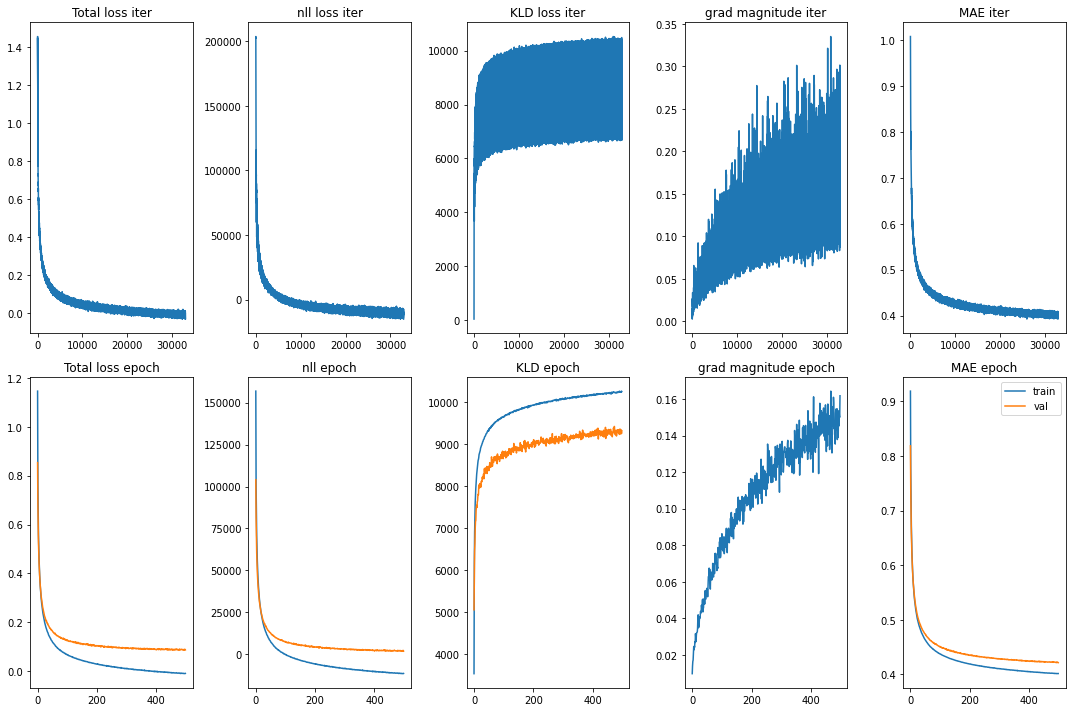

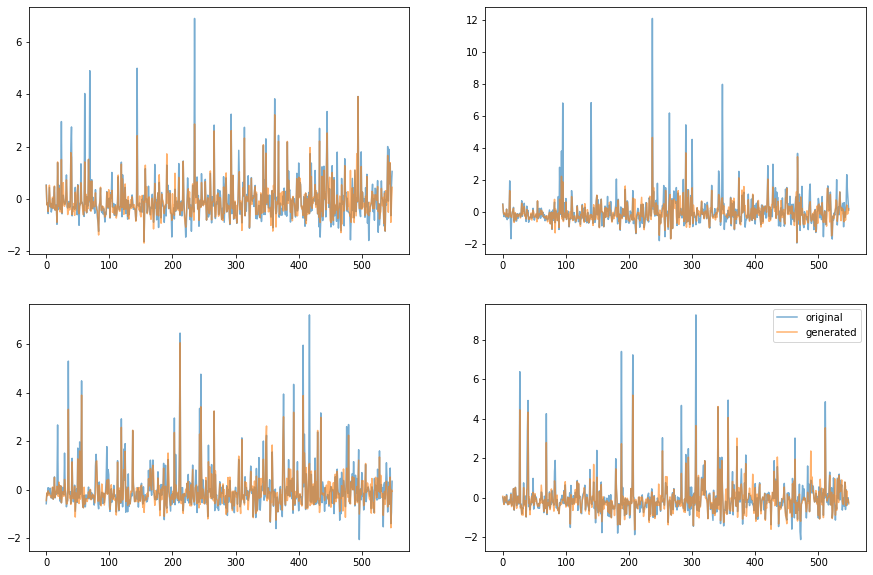

In [15]:
history_train = defaultdict(list)
history_val = defaultdict(list)

iterator = range(epochs) if plot else tqdm_notebook(range(epochs)) 
for epoch in iterator:
    model.train()
    for itr, data in enumerate(train_loader):       
        # reset the gradients back to zero
        # PyTorch accumulates gradients on subsequent backward passes
        optimizer.zero_grad()
        
        # compute reconstructions
        data = data.float().cuda()
        
        if denoising:
            data = data + 1e-2*torch.randn_like(data).cuda()
        
        with torch.autograd.detect_anomaly():
            # compute training reconstruction loss
            if model.__class__.__name__ == 'AE':
                mu_gen = model(data)
            elif model.__class__.__name__ == 'VAE':
                mu_gen, logsigma_gen, mu_z, logsigma_z = model(data)
            else: 
                raise RuntimeError()
    
            if loss_type == 'mse':
                train_loss = criterion(mu_gen, data)
                kld_loss, loss = torch.tensor(0), torch.tensor(0)
            elif loss_type == 'nll':
                train_loss, kld_loss, loss = loss_vae(data, mu_gen, logsigma_gen, mu_z, logsigma_z)
            elif loss_type == 'bce':
                loss = F.binary_cross_entropy(mu_gen, data, reduction='sum')
                kld_loss = KL_divergence(mu_z, logsigma_z)
                train_loss = loss + kld_loss
            else:
                raise RuntimeError()
            
            # compute accumulated gradients
            train_loss.backward()
            
            # metrics
            if clip_grads:
                MAX_GRAD = 1
                torch.nn.utils.clip_grad_value_(model.parameters(), MAX_GRAD)
                assert max([param.grad.abs().max().item() for param in model.parameters()]) <= MAX_GRAD
            
            grad_magnitude = calc_gradient_magnitude(filter(lambda x: x[1].requires_grad, \
                                                                  model.named_parameters()), silence=False)
            MAE = torch.norm(data - mu_gen, p=1, dim=1) / torch.norm(data, p=1, dim=1)
            MAE = MAE.mean()
            
            # perform parameter update based on current gradients
            optimizer.step()

        history_train['total_loss'].append(train_loss.item())
        history_train[f'{loss_type}_loss'].append(loss.item())
        history_train['kld_loss'].append(kld_loss.item())
        history_train['MAE'].append(MAE.item())
        history_train['grad_magnitude'].append(grad_magnitude)

        
        if (itr%100) == 0:
            clear_output(wait=True)
            fig, axes = plt.subplots(ncols=5, nrows=2, figsize=(15,10))
            
            #--------TRAIN
            axes[0,0].plot(history_train['total_loss'])
            axes[0,0].set_title(f'Total loss iter')

            axes[0,1].plot(history_train[f'{loss_type}_loss'])
            axes[0,1].set_title(f'{loss_type} loss iter')

            axes[0,2].plot(history_train['kld_loss'])
            axes[0,2].set_title(f'KLD loss iter')
            
            axes[0,3].plot(history_train['grad_magnitude'])
            axes[0,3].set_title(f'grad magnitude iter')
            
            axes[0,4].plot(history_train['MAE'])
            axes[0,4].set_title(f'MAE iter')
            
            #----------EPOCH
            
            axes[1,0].plot(history_train['total_loss_epoch'], label='train')
            axes[1,0].plot(history_val['total_loss'], label='val')
            axes[1,0].set_title(f'Total loss epoch')

            axes[1,1].plot(history_train[f'{loss_type}_loss_epoch'], label='train')
            axes[1,1].plot(history_val[f'{loss_type}_loss'], label='val')
            axes[1,1].set_title(f'{loss_type} epoch')

            axes[1,2].plot(history_train['kld_loss_epoch'], label='train')
            axes[1,2].plot(history_val['kld_loss'], label='val')
            axes[1,2].set_title(f'KLD epoch')
            
            axes[1,3].plot(history_train['grad_magnitude_epoch'], label='train')
            axes[1,3].set_title(f'grad magnitude epoch')
            
            axes[1,4].plot(history_train['MAE_epoch'], label='train')
            axes[1,4].plot(history_val['MAE'], label='val')
            axes[1,4].set_title(f'MAE epoch')
            plt.legend()
            plt.tight_layout()
            plt.show()

    # END of the epoch
    history_train['total_loss_epoch'].append(np.mean(history_train['total_loss'][-len(train_loader):]))
    history_train['MAE_epoch'].append(np.mean(history_train['MAE'][-len(train_loader):]))
    history_train[f'{loss_type}_loss_epoch'].append(np.mean(history_train[f'{loss_type}_loss'][-len(train_loader):]))
    history_train['kld_loss_epoch'].append(np.mean(history_train['kld_loss'][-len(train_loader):]))
    history_train['grad_magnitude_epoch'].append(np.mean(history_train['grad_magnitude'][-len(train_loader):]))    
    
    history_val_item = validate(model, val_loader, loss_type)
    for k,v in history_val_item.items():
        history_val[k].append(v)

# Calculate embeddings

In [88]:
X_std_tensor = torch.from_numpy(X_std).cuda().float()
if model.__class__.__name__ == 'AE':
    embedding = model.encoder(X_std_tensor)
elif model.__class__.__name__ == 'VAE':
    _, embedding, _ = model.get_code(X_std_tensor)
embedding_numpy = embedding.detach().cpu().numpy()

In [89]:
# embedding_name = f'AE{inter_dim}_dim-{code_dim}_ep-{epochs}' + ('denoise-' + str(denoising_weight) if denoising else '') + '_MSE'
# np.save(os.path.join('./embeddings',embedding_name), embedding_numpy)

# Plot results

In [ ]:
### dims_combinations = list(combinations(np.arange(code_dim), 2))
n_vis = np.floor(np.sqrt(len(dims_combinations))).astype(int)

fig, axes = plt.subplots(ncols=n_vis, nrows=n_vis, figsize=(n_vis*5,n_vis*5))
for i, ax in enumerate(axes.flatten()):
    d1,d2 = dims_combinations[i]
    ax.scatter(embedding_numpy[:,d1], embedding_numpy[:,d2], alpha=0.1, c=phi)
    ax.set_title(f'DIMS: {d1},{d2}')
plt.tight_layout()

# Manifold Learning (to compare with AE results)

In [297]:
from sklearn.preprocessing import StandardScaler
d_scaled = StandardScaler().fit_transform(d.T)
lem = SpectralEmbedding(n_components=10, n_neighbors=150)
lem_emb = lem.fit_transform(d_scaled)

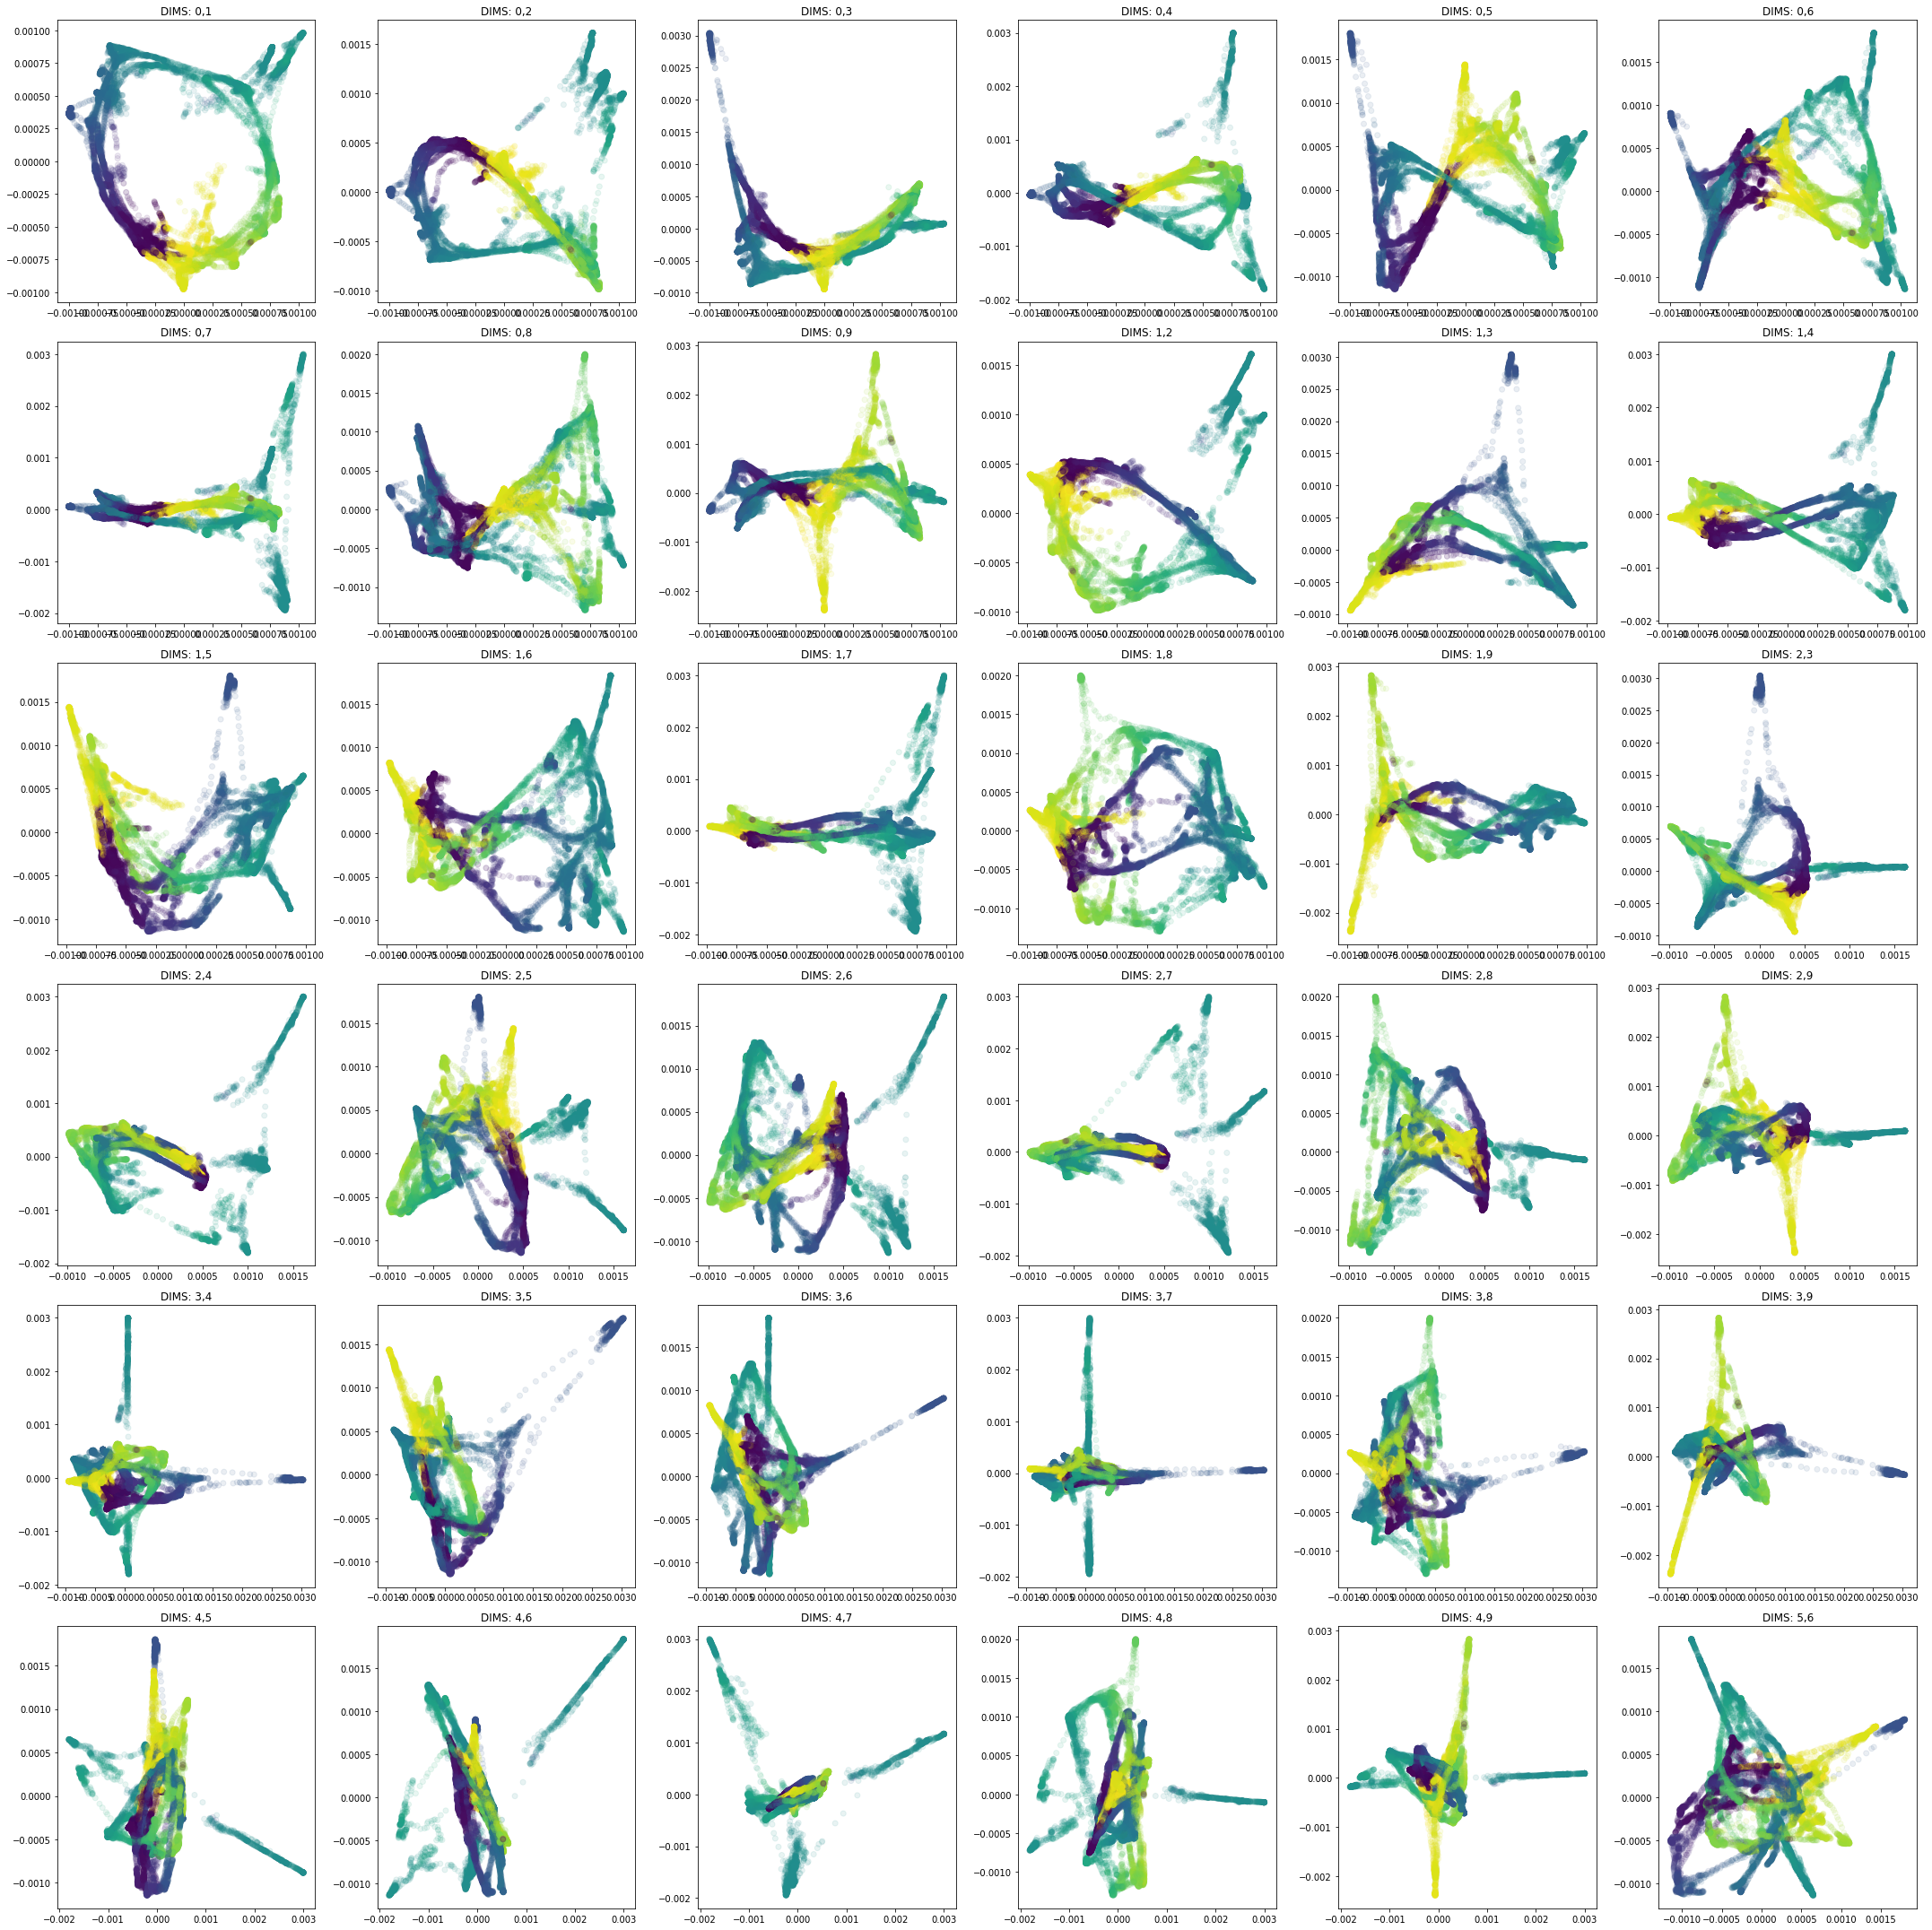

In [565]:
dims_combinations = list(combinations(np.arange(10), 2))
n_vis = np.floor(np.sqrt(len(dims_combinations))).astype(int)

fig, axes = plt.subplots(ncols=n_vis, nrows=n_vis, figsize=(n_vis*5,n_vis*5))
for i, ax in enumerate(axes.flatten()):
    d1,d2 = dims_combinations[i]
    ax.scatter(lem_emb[:,d1], lem_emb[:,d2], alpha=0.1, c=phi)
    ax.set_title(f'DIMS: {d1},{d2}')
plt.tight_layout()